# **Middle-Fusion_Mask**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Valentina Barbera, Vittorio Haardt, Luca Porcelli, Luca Sinanaj

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Progetto/Data.zip" -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/Data/TCGA-CS-6188/flair_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_79.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_82.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_83.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_85.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_89.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_92.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_94.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_57.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_58.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_63.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_65.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_67.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_68.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_73.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_75.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_79.nii.gz  
  infla

In [ ]:
#!unzip "/content/drive/MyDrive/Medical Imaging & Big Data/Progetto/Data.zip" -d Data

# Installing packages and loading libraries

In [84]:
from torch.utils.data import DataLoader
import torch
import sys
#sys.path.append('/content/drive/MyDrive/Medical Imaging & Big Data/Progetto')
sys.path.append('/content/drive/MyDrive/Progetto')
from dataset import BraTS
import numpy as np
import random
from glob import glob
import torchvision.transforms as transforms
from unet_model_MF import UNet
from torch.nn import functional as F
from tqdm import tqdm

import os
import logging
from time import time
from os.path import dirname as up
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt

# Seed

In [4]:
def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Data

### Reproducibility

In [5]:
seed_all(0)
g=torch.Generator()
g.manual_seed(0)

### Construct Data loader

In [ ]:
dataset_train = BraTS("/content/Data/Data", 'train', True)
dataset_val = BraTS("/content/Data/Data", 'val', True)

Loading val data: 100%|██████████| 34/34 [00:07<00:00,  4.34it/s]


In [6]:
dataset_test = BraTS("/content/Data/Data", 'test', True)

Loading test data: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


In [ ]:
train_loader = DataLoader(dataset_train,
                          batch_size = 5,
                          shuffle = True,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g,
                          drop_last=True)

In [ ]:
val_loader = DataLoader(dataset_val,
                          batch_size = 5,
                          shuffle = False,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g)

In [7]:
test_loader = DataLoader(dataset_test,
                          batch_size = 1,
                          shuffle = False)

# GPU presence check

In [8]:
# Use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 2 is the number of input band and 4 are the classes including the background
model = UNet(2, 4)

model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

# Training

### Cross Entropy Loss & adam optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Learning Rate scheduler

In [ ]:
reduce_lr_on_plateau=0
if reduce_lr_on_plateau==1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, '[45,65]', gamma=0.1)

### Start training

In [ ]:
epochs = 100
eval_every = 1

In [ ]:
# Train
model.train()

train_losses = []  # List to record training losses
val_losses = []    # List to record validation losses

for epoch in tqdm(range(1, epochs + 1)):
    training_loss = []
    training_batches = 0
    for it, (image, target) in enumerate(train_loader):

        image = image.to(device)
        target = target.to(device).long()

        optimizer.zero_grad()  # Resets gradients
        logits2 = F.upsample(input=model(image[:, [0,4], :, :], image[:, [1,4], :, :], image[:, [2,4], :, :], image[:, [3,4], :, :]), size=image.size()[2:4], mode='bilinear')
        loss = criterion(logits2, target)  # Computes the loss function

        loss.backward()  # Computes gradients
        training_batches += target.shape[0]  # Updates the count of training batches
        training_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
        torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf'))  # Applies gradient clipping
        optimizer.step()  # Updates model weights using the optimizer

    print("Training loss was: " + str(sum(training_loss) / training_batches))  # Prints the average training loss per epoch
    train_losses.append(sum(training_loss) / training_batches)  # Records the average training loss per epoch in the list

    # Saves the model
    model_dir = os.path.join(os.path.join(up(os.path.abspath("/content/drive/MyDrive/Progetto/results")), 'trained_models_MF_mask'), str(epoch))
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))

    if epoch % eval_every == 0 or epoch == 1:  # Evaluates the model on validation data
        model.eval()
        val_loss = []
        val_batches = 0
        y_true_val = []
        y_predicted_val = []
        seed_all(0)
        with torch.no_grad():
            for (image, target) in val_loader:

                image = image.to(device)
                target = target.to(device).long()

                logits = model(image[:, [0,4], :, :], image[:, [1,4], :, :], image[:, [2,4], :, :], image[:, [3,4], :, :]) # Runs the model
                logits = F.upsample(input=logits, size=(target.shape[-2], target.shape[-1]), mode='bilinear') # Bilinear upsampling of logits
                loss = criterion(logits, target)  # Computes the loss function

                logits = torch.movedim(logits, (0, 1, 2, 3), (0, 3, 1, 2))  # Moves dimensions to compute probabilities
                logits = logits.reshape((-1, 4))  # Reshapes logits
                target = target.reshape(-1)  # Reshapes targets
                mask = target != 0  # Creates a mask for non-empty targets

                logits = logits[mask]
                target = target[mask]

                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Computes probabilities
                target = target.cpu().numpy()
                val_batches += target.shape[0]  # Updates the count of validation batches
                val_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
                y_predicted_val += probs.argmax(1).tolist()  # Adds predictions to the list
                y_true_val += target.tolist()  # Adds true targets to the list

            y_predicted_val = np.asarray(y_predicted_val)
            y_true_val = np.asarray(y_true_val)
            subset_acc = accuracy_score(y_true_val, y_predicted_val)  # Computes accuracy
            print("Acc" + str(subset_acc))  # Prints accuracy

        val_losses.append(sum(val_loss) / val_batches)  # Records the average validation loss per epoch in the list
        scheduler.step()  # Updates the scheduler
        model.train()  # Restores the model to training mode

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.2043092494540744


  1%|          | 1/100 [01:06<1:49:28, 66.35s/it]

Acc0.0007137378789491866


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.133702891667684


  2%|▏         | 2/100 [02:12<1:48:34, 66.47s/it]

Acc0.0007224287511433928


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.0772829341888428


  3%|▎         | 3/100 [03:19<1:47:43, 66.63s/it]

Acc0.01219872548359272


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.023561364279853


  4%|▍         | 4/100 [04:26<1:46:51, 66.78s/it]

Acc0.14330705068733934


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9718480198471634


  5%|▌         | 5/100 [05:33<1:45:42, 66.76s/it]

Acc0.13124737915885393


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9303211572435167


  6%|▌         | 6/100 [06:40<1:44:45, 66.87s/it]

Acc0.35142193532687455


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8975088317305954


  7%|▋         | 7/100 [07:47<1:43:29, 66.77s/it]

Acc0.37759449693972663


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8692014047834609


  8%|▊         | 8/100 [08:53<1:42:25, 66.80s/it]

Acc0.2369816166325912


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8462124951680501


  9%|▉         | 9/100 [10:01<1:41:33, 66.96s/it]

Acc0.40092079790897617


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8291063305183693


 10%|█         | 10/100 [11:08<1:40:24, 66.94s/it]

Acc0.485724156061992


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8156800029895924


 11%|█         | 11/100 [12:14<1:39:14, 66.90s/it]

Acc0.3921549669420949


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.805134337566517


 12%|█▏        | 12/100 [13:21<1:38:03, 66.86s/it]

Acc0.5315837159127698


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7969436382364343


 13%|█▎        | 13/100 [14:28<1:36:56, 66.85s/it]

Acc0.4019235072883827


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7901222764121162


 14%|█▍        | 14/100 [15:35<1:35:43, 66.78s/it]

Acc0.5237369446804258


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7850951323685823


 15%|█▌        | 15/100 [16:41<1:34:31, 66.72s/it]

Acc0.5461735176087934


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7801815903628314


 16%|█▌        | 16/100 [17:48<1:33:27, 66.76s/it]

Acc0.3735869184991733


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7765906261514735


 17%|█▋        | 17/100 [18:55<1:32:12, 66.66s/it]

Acc0.4545825882721025


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7738147108643143


 18%|█▊        | 18/100 [20:01<1:31:05, 66.66s/it]

Acc0.25238510123779745


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7711228891655251


 19%|█▉        | 19/100 [21:08<1:30:11, 66.81s/it]

Acc0.5442158986470484


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7686914376859312


 20%|██        | 20/100 [22:15<1:29:12, 66.90s/it]

Acc0.560589501860933


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7664608310770106


 21%|██        | 21/100 [23:22<1:28:01, 66.85s/it]

Acc0.5978874662413933


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7649639126106544


 22%|██▏       | 22/100 [24:29<1:27:00, 66.94s/it]

Acc0.5913649666596416


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7634994365550853


 23%|██▎       | 23/100 [25:36<1:25:50, 66.89s/it]

Acc0.594734852352945


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7620031436284384


 24%|██▍       | 24/100 [26:43<1:24:41, 66.87s/it]

Acc0.5558714446185034


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7611180116512157


 25%|██▌       | 25/100 [27:50<1:23:40, 66.95s/it]

Acc0.5888218001838119


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7605310772083423


 26%|██▌       | 26/100 [28:56<1:22:21, 66.78s/it]

Acc0.35916007065679095


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7594349061118232


 27%|██▋       | 27/100 [30:03<1:21:08, 66.69s/it]

Acc0.5608165508970067


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7585448037253486


 28%|██▊       | 28/100 [31:10<1:20:08, 66.78s/it]

Acc0.6329116811840444


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7576152467727661


 29%|██▉       | 29/100 [32:17<1:19:03, 66.81s/it]

Acc0.5744992428077601


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7579029116807161


 30%|███       | 30/100 [33:24<1:17:59, 66.85s/it]

Acc0.5993127692812431


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7565818498752735


 31%|███       | 31/100 [34:31<1:16:56, 66.91s/it]

Acc0.5921634405424843


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7561586012663665


 32%|███▏      | 32/100 [35:38<1:15:56, 67.00s/it]

Acc0.5664330270525124


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7556675423516167


 33%|███▎      | 33/100 [36:45<1:14:41, 66.89s/it]

Acc0.6170291122491326


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.755910431543986


 34%|███▍      | 34/100 [37:51<1:13:27, 66.77s/it]

Acc0.5509665336238981


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7547446697729605


 35%|███▌      | 35/100 [38:58<1:12:21, 66.79s/it]

Acc0.5738517728292917


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7549933048530861


 36%|███▌      | 36/100 [40:05<1:11:11, 66.74s/it]

Acc0.5665807718798139


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7544071146293923


 37%|███▋      | 37/100 [41:11<1:10:04, 66.74s/it]

Acc0.5801341870666785


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7540714113800614


 38%|███▊      | 38/100 [42:18<1:08:59, 66.76s/it]

Acc0.5970086017907542


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7535553202805696


 39%|███▉      | 39/100 [43:25<1:07:50, 66.73s/it]

Acc0.5211057831236299


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7532576589231138


 40%|████      | 40/100 [44:32<1:06:43, 66.72s/it]

Acc0.664435647350479


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7530396883576005


 41%|████      | 41/100 [45:38<1:05:38, 66.75s/it]

Acc0.5828468255502952


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.753514373920582


 42%|████▏     | 42/100 [46:45<1:04:30, 66.73s/it]

Acc0.648907231457481


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7523765512749001


 43%|████▎     | 43/100 [47:52<1:03:23, 66.73s/it]

Acc0.659113574490552


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7524592274206656


 44%|████▍     | 44/100 [48:58<1:02:16, 66.72s/it]

Acc0.6798554273410494


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7521395361865009


 45%|████▌     | 45/100 [50:05<1:01:13, 66.79s/it]

Acc0.6672058628623823


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7515695227517022


 46%|████▌     | 46/100 [51:13<1:00:20, 67.04s/it]

Acc0.6814686704920989


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7516144754268504


 47%|████▋     | 47/100 [52:21<59:21, 67.20s/it]  

Acc0.6929406217884512


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7512638355184484


 48%|████▊     | 48/100 [53:28<58:13, 67.18s/it]

Acc0.649222275574521


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7509890000025431


 49%|████▉     | 49/100 [54:35<57:00, 67.07s/it]

Acc0.6951872122506535


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7514751678042941


 50%|█████     | 50/100 [55:41<55:49, 66.98s/it]

Acc0.6567746435112862


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511086974320589


 51%|█████     | 51/100 [56:49<54:47, 67.09s/it]

Acc0.5954898718748167


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7507346529430813


 52%|█████▏    | 52/100 [57:55<53:36, 67.00s/it]

Acc0.6296417405209743


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7510148673587376


 53%|█████▎    | 53/100 [59:02<52:25, 66.93s/it]

Acc0.6779977534095378


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7509481795628865


 54%|█████▍    | 54/100 [1:00:09<51:18, 66.91s/it]

Acc0.6489637221267434


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750340609020657


 55%|█████▌    | 55/100 [1:01:16<50:05, 66.78s/it]

Acc0.6754111325727372


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750317415661282


 56%|█████▌    | 56/100 [1:02:22<48:53, 66.68s/it]

Acc0.6918564354822239


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505844494148537


 57%|█████▋    | 57/100 [1:03:28<47:44, 66.62s/it]

Acc0.6481000667024441


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503386755342837


 58%|█████▊    | 58/100 [1:04:35<46:40, 66.68s/it]

Acc0.6816718196296385


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7499348428514269


 59%|█████▉    | 59/100 [1:05:42<45:34, 66.71s/it]

Acc0.6590016795110515


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7499646970960829


 60%|██████    | 60/100 [1:06:49<44:27, 66.68s/it]

Acc0.6754437233434655


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7499346967979714


 61%|██████    | 61/100 [1:07:56<43:24, 66.78s/it]

Acc0.6828407419397592


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505638318591648


 62%|██████▏   | 62/100 [1:09:02<42:14, 66.71s/it]

Acc0.6734002820188028


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7501517749715735


 63%|██████▎   | 63/100 [1:10:09<41:07, 66.70s/it]

Acc0.6900324386804648


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7495216201852869


 64%|██████▍   | 64/100 [1:11:16<40:03, 66.77s/it]

Acc0.6157146178297589


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494340543393736


 65%|██████▌   | 65/100 [1:12:22<38:54, 66.71s/it]

Acc0.70150764905389


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7497192130265412


 66%|██████▌   | 66/100 [1:13:29<37:48, 66.72s/it]

Acc0.7090600169906551


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.749620442920261


 67%|██████▋   | 67/100 [1:14:36<36:42, 66.75s/it]

Acc0.6831047271826582


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7496809754548249


 68%|██████▊   | 68/100 [1:15:42<35:29, 66.56s/it]

Acc0.7038900343941267


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7493489177138717


 69%|██████▉   | 69/100 [1:16:48<34:18, 66.41s/it]

Acc0.6328345496933209


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7493838478017736


 70%|███████   | 70/100 [1:17:54<33:10, 66.34s/it]

Acc0.7307241886527627


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494594397368255


 71%|███████   | 71/100 [1:19:01<32:06, 66.43s/it]

Acc0.6987015836941856


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7496473008614999


 72%|███████▏  | 72/100 [1:20:07<30:57, 66.35s/it]

Acc0.6852904815395011


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7493185304712366


 73%|███████▎  | 73/100 [1:21:13<29:50, 66.33s/it]

Acc0.6991774089468183


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7489156205565841


 74%|███████▍  | 74/100 [1:22:20<28:44, 66.34s/it]

Acc0.711328334633343


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491855734365958


 75%|███████▌  | 75/100 [1:23:26<27:37, 66.29s/it]

Acc0.6542140952910682


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7506295481434575


 76%|███████▌  | 76/100 [1:24:32<26:31, 66.31s/it]

Acc0.7229382535257782


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7490020617732295


 77%|███████▋  | 77/100 [1:25:39<25:25, 66.33s/it]

Acc0.5928119968799769


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7489301245300858


 78%|███████▊  | 78/100 [1:26:45<24:18, 66.31s/it]

Acc0.7008395382539603


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488361257976955


 79%|███████▉  | 79/100 [1:27:51<23:10, 66.21s/it]

Acc0.7240865350144378


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7487073273128934


 80%|████████  | 80/100 [1:28:57<22:03, 66.19s/it]

Acc0.7184342090111309


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7487166768533212


 81%|████████  | 81/100 [1:30:03<20:56, 66.15s/it]

Acc0.6816240198325704


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.74865970381984


 82%|████████▏ | 82/100 [1:31:09<19:49, 66.06s/it]

Acc0.6089542056216907


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486016865129824


 83%|████████▎ | 83/100 [1:32:15<18:42, 66.03s/it]

Acc0.7251642031665193


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7489851181595414


 84%|████████▍ | 84/100 [1:33:21<17:37, 66.08s/it]

Acc0.6799901358600596


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488725331977562


 85%|████████▌ | 85/100 [1:34:27<16:30, 66.03s/it]

Acc0.7091784301243012


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486929411358304


 86%|████████▌ | 86/100 [1:35:33<15:23, 65.94s/it]

Acc0.7113576663269984


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7488711630856549


 87%|████████▋ | 87/100 [1:36:39<14:17, 65.95s/it]

Acc0.5981373288169768


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486342871630633


 88%|████████▊ | 88/100 [1:37:45<13:10, 65.91s/it]

Acc0.670675693585919


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486249155468411


 89%|████████▉ | 89/100 [1:38:50<12:04, 65.83s/it]

Acc0.7032881914946779


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486712893733272


 90%|█████████ | 90/100 [1:39:56<10:58, 65.83s/it]

Acc0.7050133296252279


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7485634572417648


 91%|█████████ | 91/100 [1:41:02<09:51, 65.73s/it]

Acc0.6740857745631207


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7485022043298792


 92%|█████████▏| 92/100 [1:42:07<08:45, 65.65s/it]

Acc0.692786358807004


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7491571608296147


 93%|█████████▎| 93/100 [1:43:13<07:39, 65.68s/it]

Acc0.5900776312158748


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7485493296164053


 94%|█████████▍| 94/100 [1:44:18<06:33, 65.65s/it]

Acc0.6767821176613732


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7482548079667268


 95%|█████████▌| 95/100 [1:45:24<05:28, 65.62s/it]

Acc0.7223809513463247


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7481222631313182


 96%|█████████▌| 96/100 [1:46:30<04:23, 65.80s/it]

Acc0.7121311539522828


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7482975103237011


 97%|█████████▋| 97/100 [1:47:36<03:17, 65.82s/it]

Acc0.7262733757303048


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7481632328033447


 98%|█████████▊| 98/100 [1:48:42<02:11, 65.77s/it]

Acc0.7162234683967297


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7483333425168638


 99%|█████████▉| 99/100 [1:49:47<01:05, 65.75s/it]

Acc0.6981312452064408


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7486220370398627


100%|██████████| 100/100 [1:50:53<00:00, 66.54s/it]

Acc0.6971730765470295


### Loss visualization for epochs

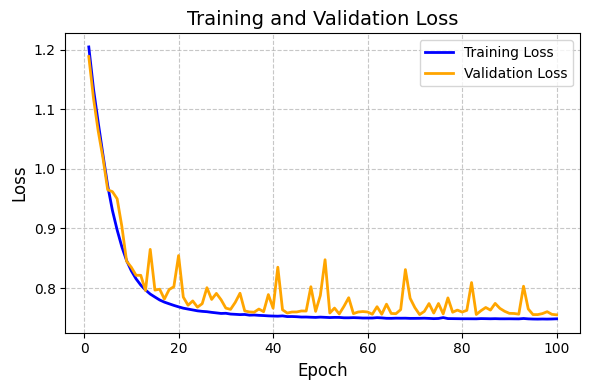

In [ ]:
plt.figure(figsize=(6, 4))

epochs = len(train_losses)

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

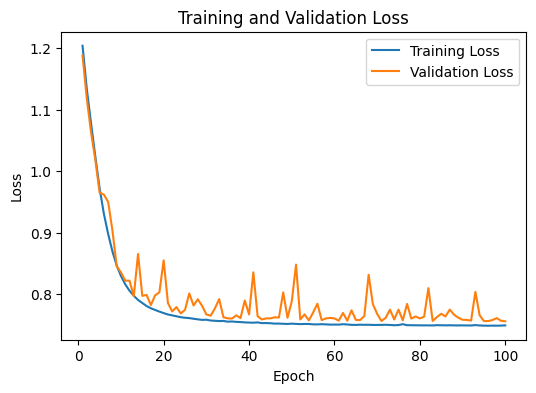

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

### Loading model

In [85]:
models_list = []
models_files = glob(os.path.join(os.path.join("/content/drive/MyDrive/Progetto/trained_models_MF_mask/", '100'),'*.pth'))

for model_file in models_files:

    model = UNet(2, 4)

    model.to(device)

    # Load model from specific epoch to continue the training or start the evaluation
    checkpoint = torch.load(model_file, map_location = device)
    checkpoint = {k.replace('decoder','decode_head'):v for k,v in checkpoint.items() if ('proj1' not in k) and ('proj2' not in k)}

    # Modify keys in the loaded checkpoint dictionary to match the model's expected keys
    checkpoint = {k.replace('decode_head', 'decoder'): v for k, v in checkpoint.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.eval()

    models_list.append(model)

### Evaluation

In [86]:
a=[]
b=[]
inputs_list = []
y_true = []
y_predicted = []

In [87]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_label in range(1, num_classes):
        y_true_class = [1 if x == class_label else 0 for x in y_true]
        y_pred_class = [1 if x == class_label else 0 for x in y_pred]
        intersection = sum(y_true_class[i] * y_pred_class[i] for i in range(len(y_true)))
        union = sum(y_true_class) + sum(y_pred_class)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice)
    return dice_scores

In [88]:
with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)
        seed_all(0)

        all_predictions = []
        logits = model(image[:, [0,4], :, :], image[:, [1,4], :, :], image[:, [2,4], :, :], image[:, [3,4], :, :])

        im_input = (image[0].detach().cpu().numpy())  # Convert the first image to a numpy array and detach from the computation graph
        inputs_list.append(im_input)  # Append the input image to a list (for visualization)

        # Accuracy metrics only on annotated pixels
        probs = torch.nn.functional.softmax(logits, dim=1)  # Compute softmax probabilities from logits
        predictions = probs.argmax(1)  # Get the class predictions by selecting the index of the maximum probability
        predictions = predictions.reshape(-1)  # Reshape predictions to a 1D array

        a.append(target.cpu().numpy())
        b.append(predictions.cpu().numpy())

        target = target.reshape(-1)  # Reshape true targets to a 1D array
        mask = target != 0  # Create a mask for non-zero targets
        predictions = predictions[mask].cpu().numpy()  # Apply the mask to predictions and convert to numpy array
        target = target[mask]  # Apply the mask to true targets
        target = target.cpu().numpy()  # Convert true targets to numpy array
        y_predicted += predictions.tolist()  # Add predictions to the list 'y_predicted'
        y_true += target.tolist()  # Add true targets to the list 'y_true'

    # Calculate and print scores
    subset_acc = accuracy_score(y_true, y_predicted)  # Compute subset accuracy
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')  # Compute IoU
    dice_coeff = dice_coefficient_multiclass(y_true, y_predicted, 4)  # Compute Dice coefficient
    print("accuracy_score: " + str(subset_acc))
    print("IoU: " + str(iou_acc))
    print("Dice coefficient: class1: " + str(dice_coeff[0]) + " class2: " + str(dice_coeff[1]) + " class3: " + str(dice_coeff[2]))

testing: 100%|██████████| 826/826 [00:11<00:00, 69.81it/s]


accuracy_score: 0.7609994666546758
IoU: 0.49361746502068937
Dice coefficient: class1: 0.7873775328328416 class2: 0.838421890670403 class3: 0.7526166814804399


### Visual evaluation

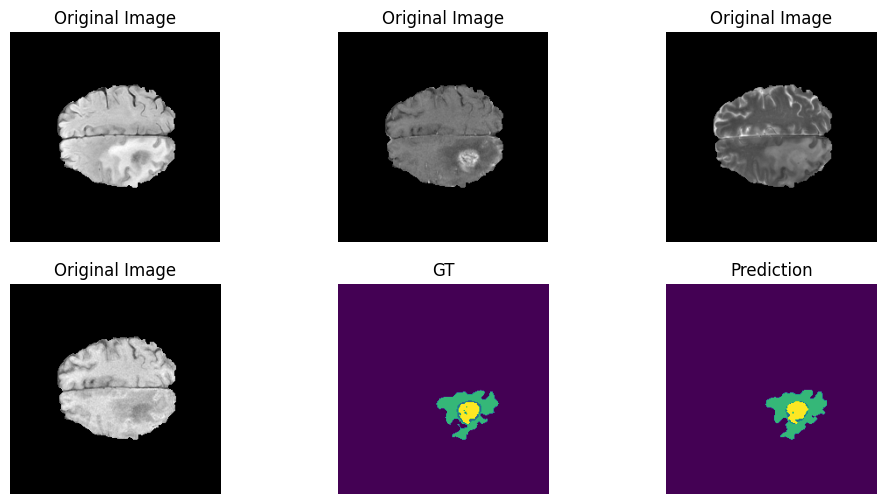

In [106]:
n = 110

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(inputs_list[n][0,:,:], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 1].imshow(inputs_list[n][1,:,:], cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 2].imshow(inputs_list[n][2,:,:], cmap='gray')
axes[0, 2].set_title('Original Image')
axes[0, 2].axis('off')
axes[1, 0].imshow(inputs_list[n][3,:,:], cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')


axes[1, 1].imshow(np.resize(a[n], (240, 240)))
axes[1, 1].set_title('GT')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.resize(b[n], (240, 240)))
axes[1, 2].set_title('Prediction')
axes[1, 2].axis('off')
plt.show()

# Test OLD


### Loading model

In [34]:
from unet_model_MF_mask import UNet

In [27]:
models_files

[]

In [35]:
models_list = []
models_files = glob(os.path.join(os.path.join("/content/drive/MyDrive/Progetto/trained_models_MF_mask_old/", '100'),'*.pth'))

for model_file in models_files:

    model = UNet(1, 4)

    model.to(device)

    # Load model from specific epoch to continue the training or start the evaluation
    checkpoint = torch.load(model_file, map_location = device)
    checkpoint = {k.replace('decoder','decode_head'):v for k,v in checkpoint.items() if ('proj1' not in k) and ('proj2' not in k)}

    # Modify keys in the loaded checkpoint dictionary to match the model's expected keys
    checkpoint = {k.replace('decode_head', 'decoder'): v for k, v in checkpoint.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.eval()

    models_list.append(model)

### Evaluation

In [36]:
a=[]
b=[]
inputs_list = []
y_true = []
y_predicted = []

In [37]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_label in range(1, num_classes):
        y_true_class = [1 if x == class_label else 0 for x in y_true]
        y_pred_class = [1 if x == class_label else 0 for x in y_pred]
        intersection = sum(y_true_class[i] * y_pred_class[i] for i in range(len(y_true)))
        union = sum(y_true_class) + sum(y_pred_class)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice)
    return dice_scores

In [49]:
with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)
        seed_all(0)

        all_predictions = []
        logits = model(image[:, 0, :, :].unsqueeze(1), image[:, 1, :, :].unsqueeze(1), image[:, 2, :, :].unsqueeze(1), image[:, 3, :, :].unsqueeze(1), image[:, 4, :, :].unsqueeze(1))

        im_input = (image[0].detach().cpu().numpy())  # Convert the first image to a numpy array and detach from the computation graph
        inputs_list.append(im_input)  # Append the input image to a list (for visualization)

        # Accuracy metrics only on annotated pixels
        probs = torch.nn.functional.softmax(logits, dim=1)  # Compute softmax probabilities from logits
        predictions = probs.argmax(1)  # Get the class predictions by selecting the index of the maximum probability
        predictions = predictions.reshape(-1)  # Reshape predictions to a 1D array

        a.append(target.cpu().numpy())
        b.append(predictions.cpu().numpy())

        target = target.reshape(-1)  # Reshape true targets to a 1D array
        mask = target != 0  # Create a mask for non-zero targets
        predictions = predictions[mask].cpu().numpy()  # Apply the mask to predictions and convert to numpy array
        target = target[mask]  # Apply the mask to true targets
        target = target.cpu().numpy()  # Convert true targets to numpy array
        y_predicted += predictions.tolist()  # Add predictions to the list 'y_predicted'
        y_true += target.tolist()  # Add true targets to the list 'y_true'

    # Calculate and print scores
    subset_acc = accuracy_score(y_true, y_predicted)  # Compute subset accuracy
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')  # Compute IoU
    dice_coeff = dice_coefficient_multiclass(y_true, y_predicted, 4)  # Compute Dice coefficient
    print("accuracy_score: " + str(subset_acc))
    print("IoU: " + str(iou_acc))
    print("Dice coefficient: class1: " + str(dice_coeff[0]) + " class2: " + str(dice_coeff[1]) + " class3: " + str(dice_coeff[2]))

testing: 100%|██████████| 826/826 [00:15<00:00, 53.53it/s]


accuracy_score: 0.2778448102502226
IoU: 0.16026459780970367
Dice coefficient: class1: 0.16921990867618864 class2: 0.305876145119389 class3: 0.5380936261288315


### Visual evaluation

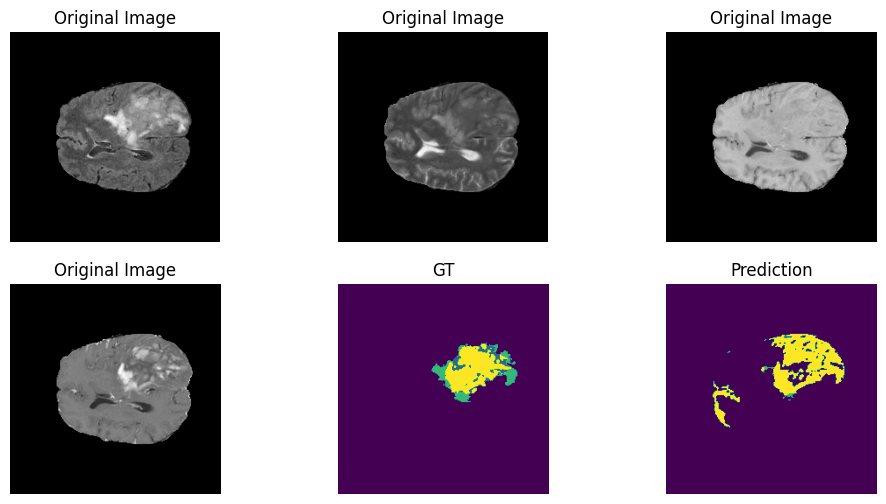

In [83]:
n = 250

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(inputs_list[n][0,:,:], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 1].imshow(inputs_list[n][1,:,:], cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 2].imshow(inputs_list[n][2,:,:], cmap='gray')
axes[0, 2].set_title('Original Image')
axes[0, 2].axis('off')
axes[1, 0].imshow(inputs_list[n][3,:,:], cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')


axes[1, 1].imshow(np.resize(a[n], (240, 240)))
axes[1, 1].set_title('GT')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.resize(b[n], (240, 240)))
axes[1, 2].set_title('Prediction')
axes[1, 2].axis('off')
plt.show()